# 1. Run the code

In [1]:
from os.path import join
import sys

import numpy as np


def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }

# Load data
LOAD_DIR = 'modified_swiss_dwellings/'
building_ids = [25, 27,49612,73]
N = len(building_ids)
building_ids = building_ids[:N]

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u
# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))



building_id, mean_temp, std_temp, pct_above_18, pct_below_15
25, 17.0022261743727, 6.7803048465418385, 51.77257696547127, 38.64807362026095
27, 14.991747695770927, 6.784942885131829, 38.51429156324369, 51.127203869085704
49612, 13.460591469095686, 6.734679615855858, 32.03209152026149, 58.8901682576236
73, 14.716036705427419, 6.786697503044278, 38.09410268637736, 52.28421554601812


# 2. Time when N=20 and estimated time for all

In [2]:
print(f'''The number of the data is {4571}
        real	3m17.537s
        user	3m17.069s
        sys	0m0.185s''')

times = (3*60+17.537)*(4571/20)
print(f"Total estimated time {int(times/60/60)} hr {int(times%3600/60)} min {int(times%60)} sec")


The number of the data is 4571
        real	3m17.537s
        user	3m17.069s
        sys	0m0.185s
Total estimated time 12 hr 32 min 27 sec


# 3. Visualization

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_51510/860412641.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.94, 1])


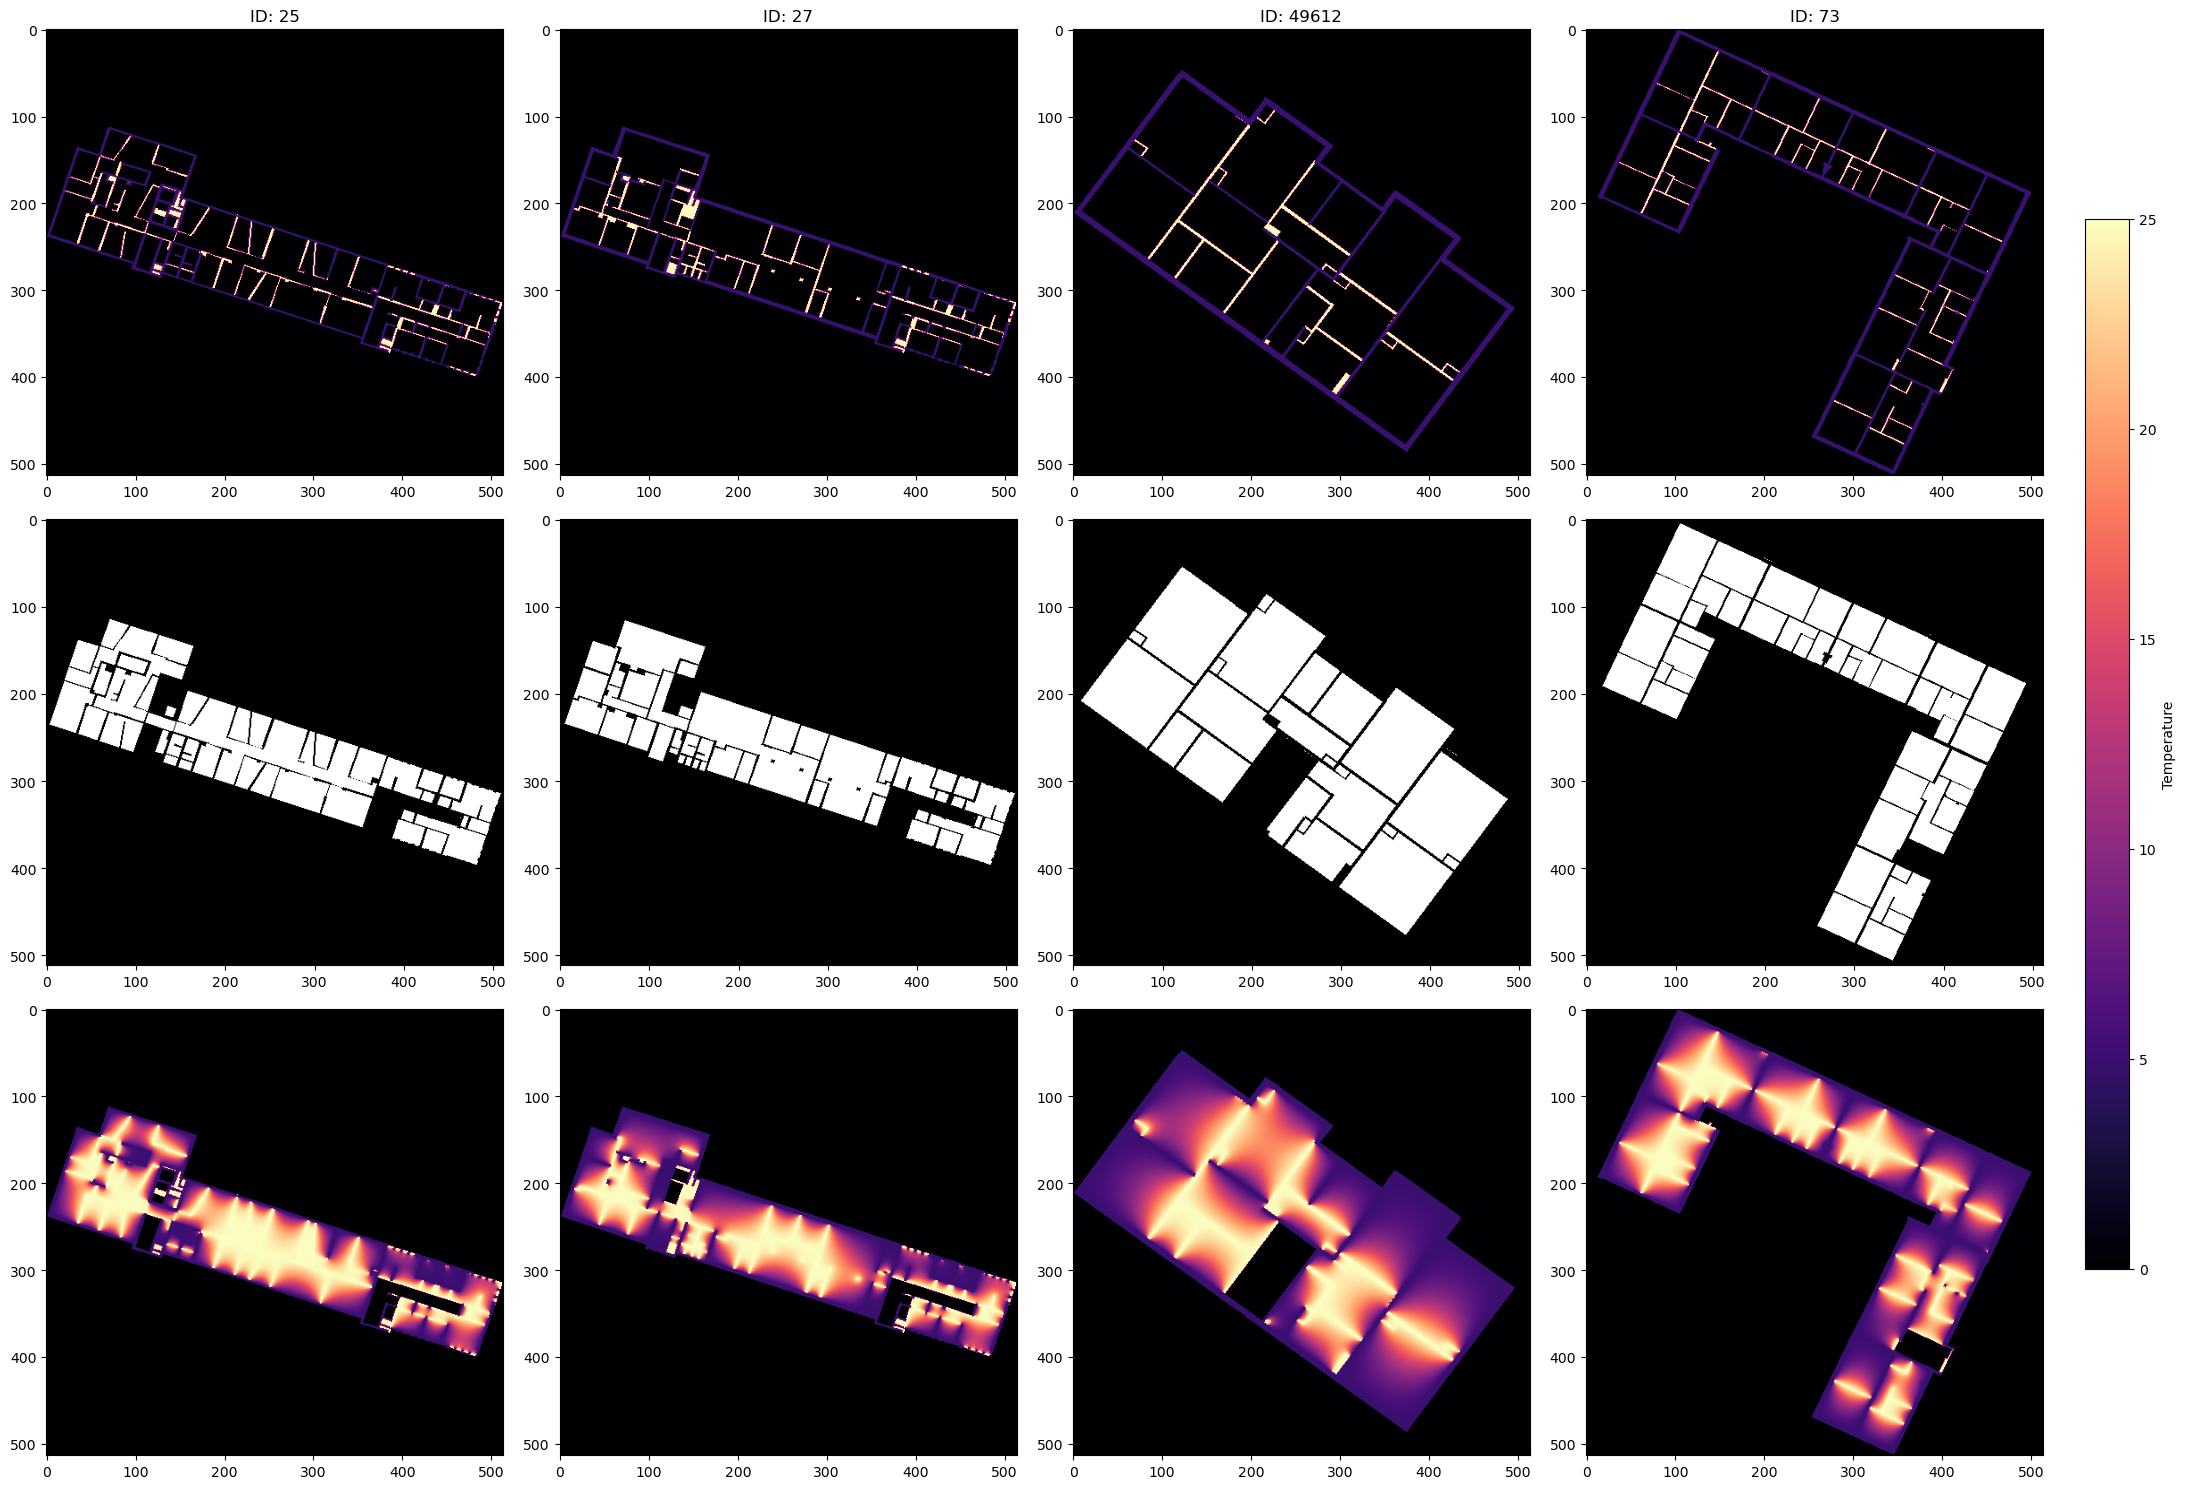

In [3]:
import matplotlib.pyplot as plt
Vis_N = 4

fig, axes = plt.subplots(3, Vis_N, figsize=(N*5+2, 15))

for i, (id, u0, interior_mask, u) in enumerate(zip(building_ids[:Vis_N], all_u0[:Vis_N], all_interior_mask[:Vis_N], all_u[:Vis_N])):
    title = f"ID: {id}"
    im = axes[0,i].imshow(u0, cmap='magma', aspect='auto')
    axes[0,i].set_title(title)
    axes[1,i].imshow(interior_mask, cmap='binary_r', aspect='auto')  
    im = axes[2,i].imshow(u, cmap='magma', aspect='auto')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  
fig.colorbar(im, cax=cbar_ax, label="Temperature")

plt.tight_layout(rect=[0, 0, 0.94, 1])  

plt.savefig("Visualize.png")

# 4. Jacobi profiling

N = 20 \
Line        Hits         Time  Per Hit%   Time  Line Contents
==============================================================
    14                                           @profile
    15                                           def jacobi(u, interior_mask, max_iter, atol=1e-6):
    16        20       6403.8    320.2      0.0      u = np.copy(u)
    17                                           
    18    118118      48632.7      0.4      0.0      for i in range(max_iter):
    19                                                   # Compute average of left, right, up and down neighbors, see eq. (1)
    20    118118  111006375.5    939.8     55.6          u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
    21    118118   21770135.5    184.3     10.9          u_new_interior = u_new[interior_mask]
    22    118118   42631144.2    360.9     21.3          delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
    23    118118   24168525.1    204.6     12.1          u[1:-1, 1:-1][interior_mask] = u_new_interior
    24                                           
    25    118118     110153.9      0.9      0.1          if delta < atol:
    26        20          9.1      0.5      0.0              break
    27        20          5.1      0.3      0.0      return u


------------------------------------------------------------

# 5 static scheduling for 20 floors

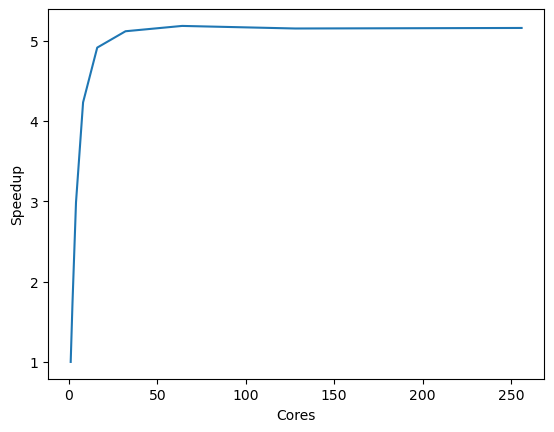

For 2 cores: Parallelizable fraction: 0.84, Serial fraction: 0.16, Max speedup: 6.27, Estimate Time: 7 hr 21 min 33 sec
For 4 cores: Parallelizable fraction: 0.89, Serial fraction: 0.11, Max speedup: 8.83, Estimate Time: 4 hr 15 min 3 sec
For 8 cores: Parallelizable fraction: 0.87, Serial fraction: 0.13, Max speedup: 7.86, Estimate Time: 3 hr 0 min 1 sec
For 16 cores: Parallelizable fraction: 0.85, Serial fraction: 0.15, Max speedup: 6.65, Estimate Time: 2 hr 35 min 1 sec
For 32 cores: Parallelizable fraction: 0.83, Serial fraction: 0.17, Max speedup: 5.90, Estimate Time: 2 hr 28 min 51 sec
For 64 cores: Parallelizable fraction: 0.82, Serial fraction: 0.18, Max speedup: 5.55, Estimate Time: 2 hr 26 min 57 sec
For 128 cores: Parallelizable fraction: 0.81, Serial fraction: 0.19, Max speedup: 5.32, Estimate Time: 2 hr 27 min 52 sec
For 256 cores: Parallelizable fraction: 0.81, Serial fraction: 0.19, Max speedup: 5.24, Estimate Time: 2 hr 27 min 40 sec


In [10]:
def amdahl_analysis(T_1, T_X, X):
    # T_1 is the time for 1 core
    # T_X is the time for X cores
    # X is the number of cores
    parralel_time_X = X*(T_1 - T_X) / (X - 1)
    # print(f"Parralel time: {parralel_time_X:.2f}")
    serial_time =(X*T_X-T_1)/(X-1)
    # print(f"Serial time: {serial_time:.2f}")

    # print ("Checking if calculation is correct")
    # time_for_1_cores = serial_time+parralel_time_X
    # time_for_X_cores = serial_time+parralel_time_X/X
    # print (f"Calculated for 1 core: {time_for_1_cores:.2f} vs real time {T_1:.2f}")
    # print (f"Calculated for {X} cores: {time_for_X_cores:.2f} vs real time {T_X:.2f}")
    P = parralel_time_X/T_1
    S = 1-P
    times = T_X*(4571/20)
    print (f"For {X} cores: Parallelizable fraction: {P:.2f}, Serial fraction: {S:.2f}, Max speedup: {1/S:.2f}, Estimate Time: {int(times/60/60)} hr {int(times%3600/60)} min {int(times%60)} sec")

import pandas as pd
df = pd.read_csv("static.csv")
T_1 = df[df["cores"] == 1]["runtime_seconds"].values[0]
import matplotlib.pyplot as plt
plt.plot(df['cores'], T_1/df['runtime_seconds'])
plt.ylabel("Speedup")
plt.xlabel("Cores")
plt.show()
# Extract single-core and multi-core rows

for X in df["cores"].unique():
    if X == 1:
        continue
    T_X = df[df["cores"] == X]["runtime_seconds"].values[0]
    amdahl_analysis(T_1, T_X, X)




# 6. Dynamic scheduling for 20 floors

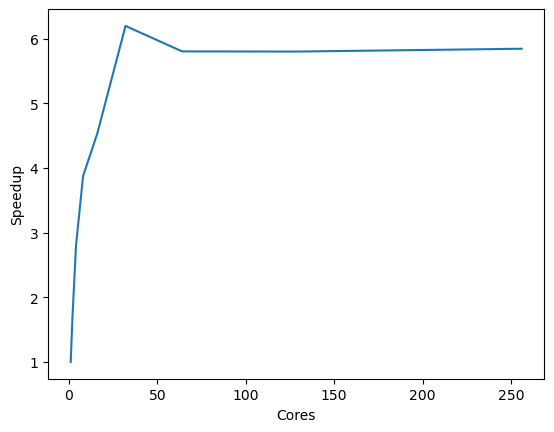

For 2 cores: Parallelizable fraction: 0.82, Serial fraction: 0.18, Max speedup: 5.51, Estimate Time: 8 hr 7 min 2 sec
For 4 cores: Parallelizable fraction: 0.86, Serial fraction: 0.14, Max speedup: 7.00, Estimate Time: 4 hr 54 min 26 sec
For 8 cores: Parallelizable fraction: 0.85, Serial fraction: 0.15, Max speedup: 6.58, Estimate Time: 3 hr 32 min 42 sec
For 16 cores: Parallelizable fraction: 0.83, Serial fraction: 0.17, Max speedup: 5.92, Estimate Time: 3 hr 2 min 0 sec
For 32 cores: Parallelizable fraction: 0.87, Serial fraction: 0.13, Max speedup: 7.45, Estimate Time: 2 hr 13 min 0 sec
For 64 cores: Parallelizable fraction: 0.84, Serial fraction: 0.16, Max speedup: 6.28, Estimate Time: 2 hr 22 min 2 sec
For 128 cores: Parallelizable fraction: 0.83, Serial fraction: 0.17, Max speedup: 6.03, Estimate Time: 2 hr 22 min 7 sec
For 256 cores: Parallelizable fraction: 0.83, Serial fraction: 0.17, Max speedup: 5.96, Estimate Time: 2 hr 21 min 3 sec


In [9]:
import pandas as pd
df = pd.read_csv("dynamic.csv")
T_1 = df[df["cores"] == 1]["runtime_seconds"].values[0]
import matplotlib.pyplot as plt
plt.plot(df['cores'], T_1/df['runtime_seconds'])
plt.ylabel("Speedup")
plt.xlabel("Cores")
plt.show()
# Extract single-core and multi-core rows

for X in df["cores"].unique():
    if X == 1:
        continue
    T_X = df[df["cores"] == X]["runtime_seconds"].values[0]
    amdahl_analysis(T_1, T_X, X)


# 7.Numba JIT on the CPU

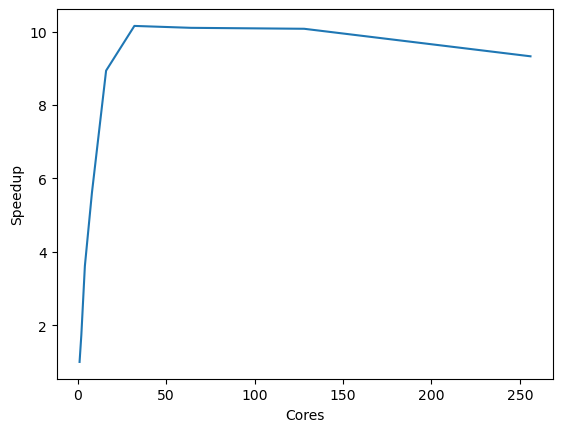

For 2 cores: Parallelizable fraction: 0.85, Serial fraction: 0.15, Max speedup: 6.55, Estimate Time: 5 hr 46 min 42 sec
For 4 cores: Parallelizable fraction: 0.96, Serial fraction: 0.04, Max speedup: 28.24, Estimate Time: 2 hr 46 min 23 sec
For 8 cores: Parallelizable fraction: 0.94, Serial fraction: 0.06, Max speedup: 16.48, Estimate Time: 1 hr 47 min 9 sec
For 16 cores: Parallelizable fraction: 0.95, Serial fraction: 0.05, Max speedup: 18.99, Estimate Time: 1 hr 7 min 18 sec
For 32 cores: Parallelizable fraction: 0.93, Serial fraction: 0.07, Max speedup: 14.41, Estimate Time: 0 hr 59 min 13 sec
For 64 cores: Parallelizable fraction: 0.92, Serial fraction: 0.08, Max speedup: 11.81, Estimate Time: 0 hr 59 min 32 sec
For 128 cores: Parallelizable fraction: 0.91, Serial fraction: 0.09, Max speedup: 10.86, Estimate Time: 0 hr 59 min 41 sec
For 256 cores: Parallelizable fraction: 0.90, Serial fraction: 0.10, Max speedup: 9.64, Estimate Time: 1 hr 4 min 29 sec


In [4]:
import pandas as pd
df = pd.read_csv("numbacpu.csv")
T_1 = df[df["cores"] == 1]["runtime_seconds"].values[0]
import matplotlib.pyplot as plt
plt.plot(df['cores'], T_1/df['runtime_seconds'])
plt.ylabel("Speedup")
plt.xlabel("Cores")
plt.show()
# Extract single-core and multi-core rows

for X in df["cores"].unique():
    if X == 1:
        continue
    T_X = df[df["cores"] == X]["runtime_seconds"].values[0]
    amdahl_analysis(T_1, T_X, X)


# 8. GPU


In [2]:
import pandas as pd
df = pd.read_csv("runtime_log_gpu.csv")
T_1 = df[df["cores"] == 1]["runtime_seconds"].values[0]
times = T_1*(4571/20)
print(f"Total estimated time {int(times/60/60)} hr {int(times%3600/60)} min {int(times%60)} sec")


Total estimated time 1 hr 28 min 45 sec


# 9. CuPy

In [4]:
import pandas as pd
df = pd.read_csv("runtime_log_gpu.csv")
T_1 = 58.7
times = T_1*(4571/20)
print(f"Total estimated time {int(times/60/60)} hr {int(times%3600/60)} min {int(times%60)} sec")

Total estimated time 3 hr 43 min 35 sec


# 9. CuPy solution using the nsys profiler
Time (%)  Total Time (ns)  Num Calls   Avg (ns)   Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
 --------  ---------------  ---------  ----------  ---------  --------  ---------  -----------  ----------------------------
     56.1      12278851633    2244662      5470.2     5402.0      3719    1834319       4020.4  cuLaunchKernel              
     32.8       7186783694     472672     15204.6    15005.0      6800    1209316       2339.2  cudaMemcpyAsync 

Time (%)  Total Time (ns)  Count   Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      Operation     
 --------  ---------------  ------  --------  --------  --------  --------  -----------  ------------------
     99.3        713542814  472572    1509.9    1472.0      1056      9824        115.4  [CUDA memcpy DtoH]

After removing most of the loop:

 Time (%)  Total Time (ns)  Num Calls   Avg (ns)   Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
 --------  ---------------  ---------  ----------  ---------  --------  ---------  -----------  ----------------------------
     96.3      49074562397      44340   1106778.6   706845.0      6967    3288353     860869.5  cudaMemcpyAsync             
      3.0       1549153944     274192      5649.9     5406.0      3968    1172399       2560.6  cuLaunchKernel                                                                              
 Time (%)  Total Time (ns)  Count  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      Operation     
 --------  ---------------  -----  --------  --------  --------  --------  -----------  ------------------
     93.6         66485336  44260    1502.2    1440.0      1088      8096        140.0  [CUDA memcpy DtoH]